A notebook which implements a basic Linear Leaky Integrate and Fire neuron, as well as a network.

Start by importing some basic py libs"

In [2]:
import numpy as np
import matplotlib.pyplot as plt 


Let's start by looking at a single neuron which we apply a constant current to (defined in const_in). Increasing const_in will increase the firing frequency, and decresing it will lower the frequency. Decreasing it below v_thresh will cease any firing at all.

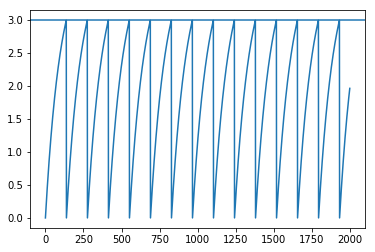

In [3]:
### A single neuron with constant input
t_end = 20
dt = 0.01 #The step size for forward Euler.
ts = np.arange(0, t_end, dt) 

#Define some parameters
v_thresh = 3#The firing threshold.
v_reset = 0# Where we go back to after crossing v_thresh.
const_in = 4# The constant input current.

# in general, I, input current,  may depend on time, but it is constant for this example.
I = lambda t: const_in
Vp = lambda t, V : -V + I(t)

# Define inital voltage
V_0 = 0 

Vt = np.empty(len(ts))
Vt[0] = V_0 

for i, t in enumerate(ts[1:]):
    Vt[i+1] = Vt[i] + dt * Vp(t, Vt[i])

    # Reset values if necessary
    if Vt[i+1] > v_thresh:
        Vt[i+1] = v_reset

plt.plot(Vt)
plt.axhline(v_thresh)
plt.show()


A single neuron, however, is not generally of interest when using an LIF model. We want to model populations. A popular way to do this is via postsynaptic kernels, here labelled alpha. Any time a neuron fires, the current of the neurons its connected to (one way connections) is increased as defined by the alpha function:

In [4]:
### A small network: 
## Neuron 1 receives input current, and has an excitatory connection to neuron 2, which similarly has an excitatory connection to neuron 3, which in turn has an inhibatory connection to neuron 1. This induces periodic behavior.
##
## (In)   (+)   (+)
## ----(1)-->(2)-->(3)
##      |           |
##      ------<------
##          (-)
# The post-synaptic potential function.
alpha = lambda(dt): 10.0 * np.exp(-dt / 0.5) - np.exp(-dt / 0.07) if dt > 0 else 0

t_end = 20
dt = 0.01 #The step size for forward Euler.
ts = np.arange(0, t_end, dt)

#Define some parameters
v_thresh = 3#The firing threshold.
v_reset = 0# Where we go back to after crossing v_thresh.
const_in = 4# The constant input function to the first neuron only.

h = 3#Number of neurons

# Define inital voltage
V_0 = np.zeros(h)

Vt = np.empty([h, len(ts)])
Vt[:,0] = V_0

# in general, I may depend on time, but it is constant for this example.
I = lambda t: const_in

# Define some weights:
W = np.zeros([h,h])
W[0,1] = 1.0
W[1,2] = 1.0
W[2,0] = -1.0

# A list of firing times for each neuron (list of lists)
F = [[] for _ in range(h)]
#' t is scalar time
#' V is a vector containing the current potential of each neuron.
def get_rhs(t, V):
    ret = np.empty(h)
    #Neuron 1 get the input current, as well as an inhibitory current from N3.
    ret[0] = I(t) + W[2,0] * sum([alpha(t - tf) for tf in F[2]])
    # Neuron 2 is excited by N1 and in turn excites N3
    ret[1] = W[0,1] * sum([alpha(t - tf) for tf in F[0]])
    # Neuron 3 is excited by N2 and inhibits N1
    ret[2] = W[1,2] * sum([alpha(t - tf) for tf in F[1]])

    return(ret)

# Solve the ODE via forward Euler. 
for t_i, t in enumerate(ts[1:]):
    # Get the RHS
    rhs = get_rhs(t, Vt[:, t_i])

    # Update the things
    for n_i in range(h):
        Vt[n_i, t_i+1] = Vt[n_i, t_i] + dt * rhs[n_i]

        # Check if any are above the threshold.
        if Vt[n_i, t_i+1] > v_thresh:
            Vt[n_i, t_i+1] = v_reset
            F[n_i].append(t)

        # Also reset if its below the value, but don't trigger the alpha func
        if (Vt[n_i, t_i+1] < v_reset):
            Vt[n_i, t_i+1] = v_reset



# plot the results
for i in range(h):
    plt.subplot(2,2,i+1)
    plt.plot(ts, Vt[i,:])
    plt.title("Neuron %i"%(i+1))
    plt.axhline(v_thresh, color = 'red')

    for t in F[(i + 2) % 3]:
        plt.axvline(t, color = 'orange', linewidth = 0.5)



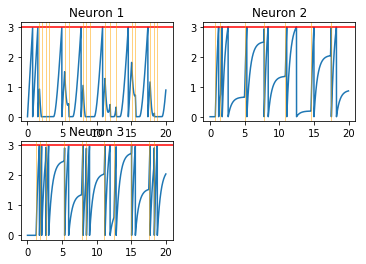

In [5]:
#The thin orange lines indicate times when a presynaptic neuron has fired:
plt.show()